# Current status of Wikidata chemical data -  an overview

In [89]:
import urllib
import pandas as pd
import numpy as np


wd_chem_data = pd.read_csv('wd_chem_2017-01-27.csv', low_memory=False, index_col=0, 
                           dtype={'drugbank': np.str, 'iuphar': np.str})

wd_chem_data['article'] = wd_chem_data.loc[wd_chem_data['article'].map(
                lambda x: pd.notnull(x)), 'article'].map(lambda x: urllib.parse.unquote(x))


wp_chem_data = pd.read_csv('wp_chem_data_2017-01-27.csv', low_memory=False, index_col=0, 
                          dtype={'pageid': np.str})

wp_chem_data['DrugBank'] = wp_chem_data.loc[wp_chem_data['DrugBank'].map(
                lambda x: pd.notnull(x)), 'DrugBank'].map(lambda x: x[2:])

wp_chem_data['ChEMBL'] = wp_chem_data.loc[wp_chem_data['ChEMBL'].map(
                lambda x: pd.notnull(x)), 'ChEMBL'].map(lambda x: '|'.join(['CHEMBL' + y for y in x.split('|')]))

# What data on chemical compounds is in Wikidata

In [90]:
wd_chem_data.count()

Unnamed: 0          158964
cmpnd.1             158964
article              16691
mass                147255
chemSpider          122616
pubchem_cid         144803
unii                 58286
mesh_id                947
kegg_id              12957
mesh_code                3
chebi                82489
drugbank              7167
chembl               49596
iuphar                5889
cas                  71443
csmiles             151661
inchi               148825
inchi_key           151447
chemical_formula    148138
atc_code              1725
ismiles              84233
dtype: int64

# What data on chemical compounds is in the English Wikipedia?

In [91]:
wp_chem_data.count()

page_title          16991
pageid              16991
SystematicName        622
OtherNames           6315
synonyms             1454
IUPHAR_ligand        2016
CASNo                9123
CAS_number           5999
UNII                 6551
SMILES               9876
KEGG                 4101
ChEMBL               6257
ChemSpiderID        14959
DrugBank             2089
PubChem             13849
StdInChI            13019
StdInChIKey         12998
InChI                7129
InChIKey             6600
ATC_code             4042
molecular_weight     5867
dtype: int64

In [121]:
import wikidataintegrator as wdi

def get_qid(iwlink):
    query = '''
    SELECT ?qid WHERE {{
        <{}> schema:about ?qid .
    }}
    '''
    
    wp_base_url = 'https://en.wikipedia.org/wiki/'
    if iwlink.startswith(wp_base_url):
        iwlink = iwlink[30:]
    elif iwlink.startswith('http://en.wikipedia.org/wiki/'):
        iwlink = iwlink[29:]
    
    iwlink = urllib.parse.quote(iwlink, safe='')
    iwlink = wp_base_url + iwlink
    
    results = wdi.wdi_core.WDItemEngine.execute_sparql_query(query=query.format(iwlink))
    
    for x in results['results']['bindings']:
        if x['qid'] and x['qid']['value']:
            return x['qid']['value']
        else:
            return ''
        
    return ''
        
        
test_url = 'https://en.wikipedia.org/wiki/Paracetamol/metoclopramide'
print(get_qid(test_url))


http://www.wikidata.org/entity/Q7133847


In [122]:
# get all Wikipedia articles w/o Wikidata item
all_stuff = set()
existing_interwiki_links = [x[30:] for x in wd_chem_data['article'].dropna()]
na_wd_count = 0
na_wd_cid_count = 0

print('''{| class="wikitable"
|-
! Wikidata item !! Wikipedia page
|-''')

for index, x in wp_chem_data.iterrows():
    if x['page_title'] not in existing_interwiki_links:
        qid = get_qid(x['page_title'])
#         print(qid)
#         print(x['page_title'])
        print('| '+ qid + ' || ' + 'https://en.wikipedia.org/wiki/{}'
              .format(x['page_title'].replace(' ', '_')) + '\n|-')
        na_wd_count += 1
        all_stuff.add(x['page_title'])
        if pd.notnull(x['PubChem']):
            na_wd_cid_count += 1

print('|}')
            
print(na_wd_count)
print(na_wd_cid_count)

{| class="wikitable"
|-
! Wikidata item !! Wikipedia page
|-
| http://www.wikidata.org/entity/Q798309 || https://en.wikipedia.org/wiki/BCG_vaccine
|-
| http://www.wikidata.org/entity/Q208413 || https://en.wikipedia.org/wiki/Botulinum_toxin
|-
| http://www.wikidata.org/entity/Q898739 || https://en.wikipedia.org/wiki/Laudanum
|-
| http://www.wikidata.org/entity/Q908104 || https://en.wikipedia.org/wiki/MMR_vaccine
|-
| http://www.wikidata.org/entity/Q1519099 || https://en.wikipedia.org/wiki/Polio_vaccine
|-
| http://www.wikidata.org/entity/Q7997549 || https://en.wikipedia.org/wiki/Whole_blood
|-
| http://www.wikidata.org/entity/Q5308141 || https://en.wikipedia.org/wiki/Dexbrompheniramine/pseudoephedrine
|-
| http://www.wikidata.org/entity/Q424427 || https://en.wikipedia.org/wiki/Antivenom
|-
| http://www.wikidata.org/entity/Q7905570 || https://en.wikipedia.org/wiki/Microbicides_for_sexually_transmitted_diseases
|-
| http://www.wikidata.org/entity/Q14860537 || https://en.wikipedia.org/wiki

In [93]:
# remove all compounds w/o Wikipedia pendant
wd_chem_data = wd_chem_data.loc[wd_chem_data['article'].notnull(), :]
wd_chem_data.drop('Unnamed: 0', inplace=True, axis=1)
# wd_chem_data['cmpnd.1'].rename('cmpnd', inplace=True)
# wd_chem_data.rename(index=str, columns={"cmpnd.1": "cmpnd"})
wd_chem_data.count()
# wd_chem_data.index

cmpnd.1             16691
article             16691
mass                13283
chemSpider          14322
pubchem_cid         14198
unii                11064
mesh_id               929
kegg_id              5065
mesh_code               3
chebi                6744
drugbank             2790
chembl               9237
iuphar               2155
cas                 15090
csmiles             14532
inchi               13992
inchi_key           14218
chemical_formula    14710
atc_code             1672
ismiles              4370
dtype: int64

# Comparison of chem data in Wikidata and Wikipedia

In [80]:
bool_df = pd.DataFrame(columns=wd_chem_data.columns, index=wd_chem_data.index)
bool_df.fillna(method='backfill')
bool_df['cmpnd'] = wd_chem_data['cmpnd.1']
bool_df['article'] = wd_chem_data['article']
bool_df.head()


,cmpnd.1,article,mass,chemSpider,pubchem_cid,unii,mesh_id,kegg_id,mesh_code,chebi,...,chembl,iuphar,cas,csmiles,inchi,inchi_key,chemical_formula,atc_code,ismiles,cmpnd
cmpnd,,,,,,,,,,,,,,,,,,,,,
http://www.wikidata.org/entity/Q161267,NaN,"https://en.wikipedia.org/wiki/1,1,1-Trifluoroe...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.wikidata.org/entity/Q161267
http://www.wikidata.org/entity/Q161264,NaN,"https://en.wikipedia.org/wiki/1,1,1,2-Tetrachl...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.wikidata.org/entity/Q161264
http://www.wikidata.org/entity/Q161275,NaN,"https://en.wikipedia.org/wiki/1,1,2,2-Tetrachl...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.wikidata.org/entity/Q161275
http://www.wikidata.org/entity/Q161276,NaN,"https://en.wikipedia.org/wiki/1,1,2-Trichloro-...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.wikidata.org/entity/Q161276
http://www.wikidata.org/entity/Q161271,NaN,https://en.wikipedia.org/wiki/Tetrabromoethane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.wikidata.org/entity/Q161271


In [81]:
for count, data in wd_chem_data.iterrows():    
    if pd.isnull(data['article']):
        continue
    
    compound_name = data['article'][30:]
    comp_cols = [
        #'mass',
        'chemSpider',
        'pubchem_cid',
        'unii',
        'kegg_id',
        'drugbank',
        'chembl',
        'iuphar',
        'cas',
        #'csmiles',
        'inchi',
        'inchi_key',
        'atc_code',
    ]
    wd_data = [set(data[col].split('|')) if pd.notnull(data[col]) else set([np.NaN]) for col in comp_cols]
#     print(wd_data)    
        
    comp_cols_1 = [
        #'molecular_weight',
        'ChemSpiderID',
        'PubChem',
        'UNII',
        'KEGG',
        'DrugBank',
        'ChEMBL',
        'IUPHAR_ligand',
        'cas',
        #'SMILES',
        'StdInChI',
        'StdInChIKey',
        'ATC_code',
    ]
    
    try:
        c, tmp_data = next(wp_chem_data.loc[wp_chem_data['page_title'].values == compound_name, 
                                            :].iterrows())
    except StopIteration:
        continue
        
    tmp_data['cas'] = '|'.join([x for x in [tmp_data['CASNo'], tmp_data['CAS_number']] if pd.notnull(x)])
    
    wp_data = [set(tmp_data[col].split('|')) if pd.notnull(tmp_data[col]) 
               else set([np.NaN]) for col in comp_cols_1]
    
    for cc, d in enumerate(wd_data):
        wd = {x for x in d if pd.notnull(x)}        
        wp = {x for x in wp_data[cc] if pd.notnull(x)}

        if len(wd.intersection(wp)) >= 1 and (len(wd) >= 1 or len(wp) >= 1):
            bool_df.loc[count, comp_cols[cc]] = True
            
        elif len(wd.intersection(wp)) < 1 and (len(wd) >= 1 and len(wp) >= 1):
            bool_df.loc[count, comp_cols[cc]] = False
    
#     if count % 1000 == 0:
#         print(count)
        
# bool_df.head(n=50)

In [82]:
bool_df.describe()


,cmpnd.1,article,mass,chemSpider,pubchem_cid,unii,mesh_id,kegg_id,mesh_code,chebi,...,chembl,iuphar,cas,csmiles,inchi,inchi_key,chemical_formula,atc_code,ismiles,cmpnd
count,0.0,16691,0.0,13056,12873,6035,0.0,3734,0.0,0.0,...,5810,1801,14565,0.0,11530,11670,0.0,1651,0.0,16691
unique,0.0,16691,0.0,2,2,2,0.0,2,0.0,0.0,...,2,2,2,0.0,2,2,0.0,2,0.0,16691
top,NaN,https://en.wikipedia.org/wiki/Afoxolaner,NaN,True,True,True,NaN,True,NaN,NaN,...,True,True,True,NaN,True,True,NaN,True,NaN,http://www.wikidata.org/entity/Q410517
freq,NaN,1,NaN,12129,11806,5794,NaN,3510,NaN,NaN,...,5392,1787,13316,NaN,10115,10153,NaN,1622,NaN,1


In [83]:
bool_df.head()

,cmpnd.1,article,mass,chemSpider,pubchem_cid,unii,mesh_id,kegg_id,mesh_code,chebi,...,chembl,iuphar,cas,csmiles,inchi,inchi_key,chemical_formula,atc_code,ismiles,cmpnd
cmpnd,,,,,,,,,,,,,,,,,,,,,
http://www.wikidata.org/entity/Q161267,NaN,"https://en.wikipedia.org/wiki/1,1,1-Trifluoroe...",NaN,True,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,NaN,True,True,NaN,NaN,NaN,http://www.wikidata.org/entity/Q161267
http://www.wikidata.org/entity/Q161264,NaN,"https://en.wikipedia.org/wiki/1,1,1,2-Tetrachl...",NaN,True,True,NaN,NaN,True,NaN,NaN,...,True,NaN,True,NaN,True,True,NaN,NaN,NaN,http://www.wikidata.org/entity/Q161264
http://www.wikidata.org/entity/Q161275,NaN,"https://en.wikipedia.org/wiki/1,1,2,2-Tetrachl...",NaN,True,True,NaN,NaN,True,NaN,NaN,...,True,NaN,True,NaN,True,True,NaN,NaN,NaN,http://www.wikidata.org/entity/Q161275
http://www.wikidata.org/entity/Q161276,NaN,"https://en.wikipedia.org/wiki/1,1,2-Trichloro-...",NaN,True,True,True,NaN,NaN,NaN,NaN,...,True,NaN,True,NaN,True,True,NaN,NaN,NaN,http://www.wikidata.org/entity/Q161276
http://www.wikidata.org/entity/Q161271,NaN,https://en.wikipedia.org/wiki/Tetrabromoethane,NaN,True,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,True,NaN,True,True,NaN,NaN,NaN,http://www.wikidata.org/entity/Q161271


In [84]:
for col in bool_df:
    # ignore non-bool columns
    if col in ['cmpnd.1', 'article', 'cmpnd']:
        continue
    print(bool_df[col].value_counts())

Series([], Name: mass, dtype: int64)
True     12129
False      927
Name: chemSpider, dtype: int64
True     11806
False     1067
Name: pubchem_cid, dtype: int64
True     5794
False     241
Name: unii, dtype: int64
Series([], Name: mesh_id, dtype: int64)
True     3510
False     224
Name: kegg_id, dtype: int64
Series([], Name: mesh_code, dtype: int64)
Series([], Name: chebi, dtype: int64)
True     1945
False      33
Name: drugbank, dtype: int64
True     5392
False     418
Name: chembl, dtype: int64
True     1787
False      14
Name: iuphar, dtype: int64
True     13316
False     1249
Name: cas, dtype: int64
Series([], Name: csmiles, dtype: int64)
True     10115
False     1415
Name: inchi, dtype: int64
True     10153
False     1517
Name: inchi_key, dtype: int64
Series([], Name: chemical_formula, dtype: int64)
True     1622
False      29
Name: atc_code, dtype: int64
Series([], Name: ismiles, dtype: int64)


In [31]:
bool_df.to_csv('bool_df.csv')

# Calculate counts

In [121]:
for count, x in bool_df.iterrows():
    t_count = [1 for k, v in x.items() if v == True]
    f_count = [1 for k, v in x.items() if v == False]
    na_count = [1 for k, v in x.items() if pd.isnull(v)]
#     print(sum(t_count), sum(f_count), sum(na_count))
    bool_df.loc[count, 't_count'] = np.NaN if sum(t_count) == 0 and sum(f_count) == 0 else sum(t_count)
    bool_df.loc[count, 'f_count'] = np.NaN if sum(t_count) == 0 and sum(f_count) == 0 else sum(f_count)
    bool_df.loc[count, 'na_count'] = sum(na_count)
#     tmp = sum(f_count) / sum(t_count) if sum(t_count) > 0 else 0
    tmp = 1 if sum(f_count) == 0 and sum(t_count) > 0 else (sum(f_count) / sum(t_count) if sum(t_count) > 0 else 0)
    bool_df.loc[count, 'percentage'] = tmp if tmp <= 1 else 1
    

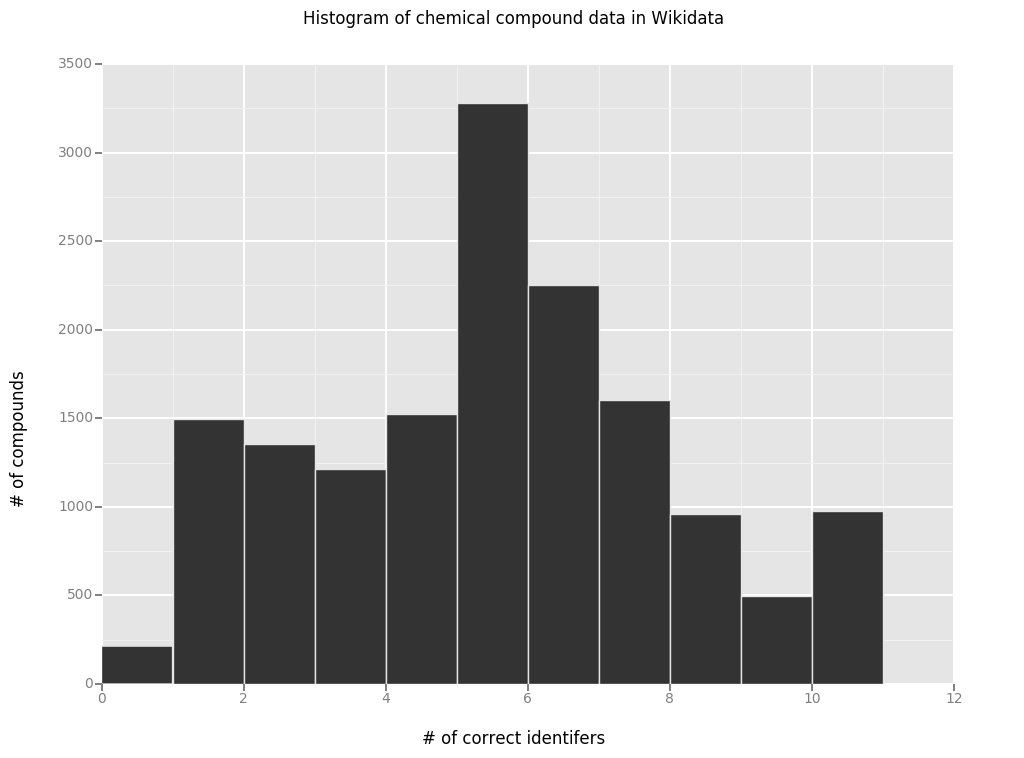

<ggplot: (8749691946216)>

In [122]:
from ggplot import *
p = ggplot(aes(x='t_count'), data=bool_df)
p + geom_histogram(binwidth=1) + ggtitle('Histogram of chemical compound data in Wikidata') + xlab('# of correct identifers') + ylab('# of compounds')


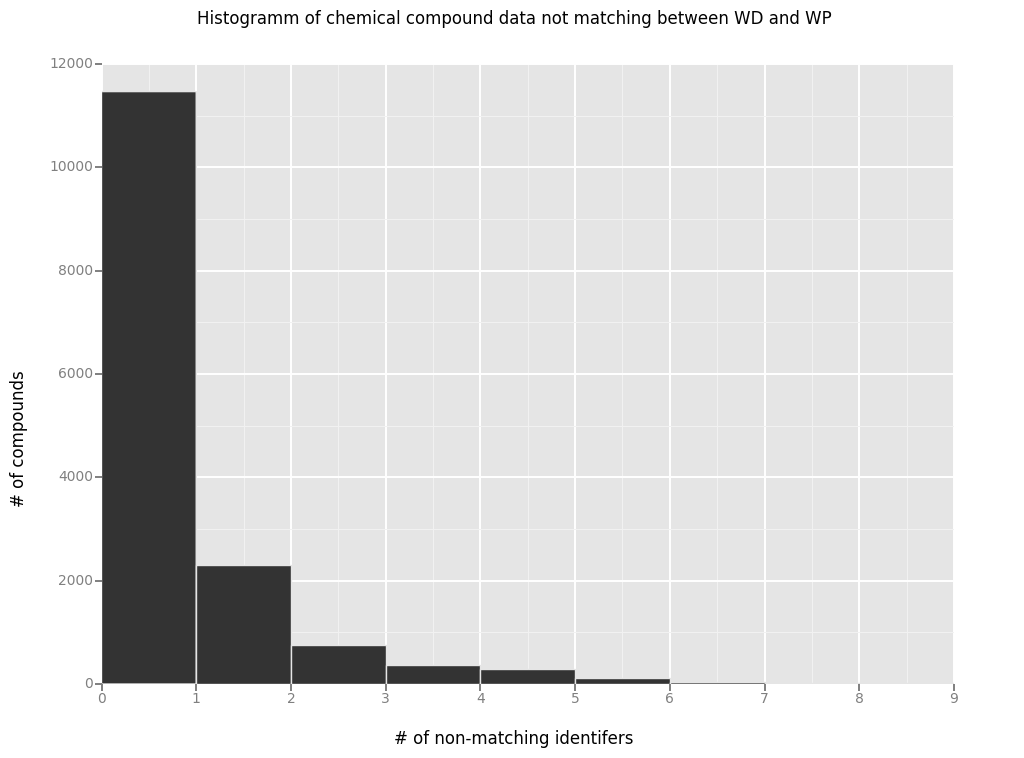

<ggplot: (-9223363287177120659)>

In [123]:
p2 = ggplot(aes(x='f_count'), data=bool_df)
p2 + geom_histogram(binwidth=1) + ggtitle('Histogramm of chemical compound data not matching between WD and WP') + xlab('# of non-matching identifers') + ylab('# of compounds')

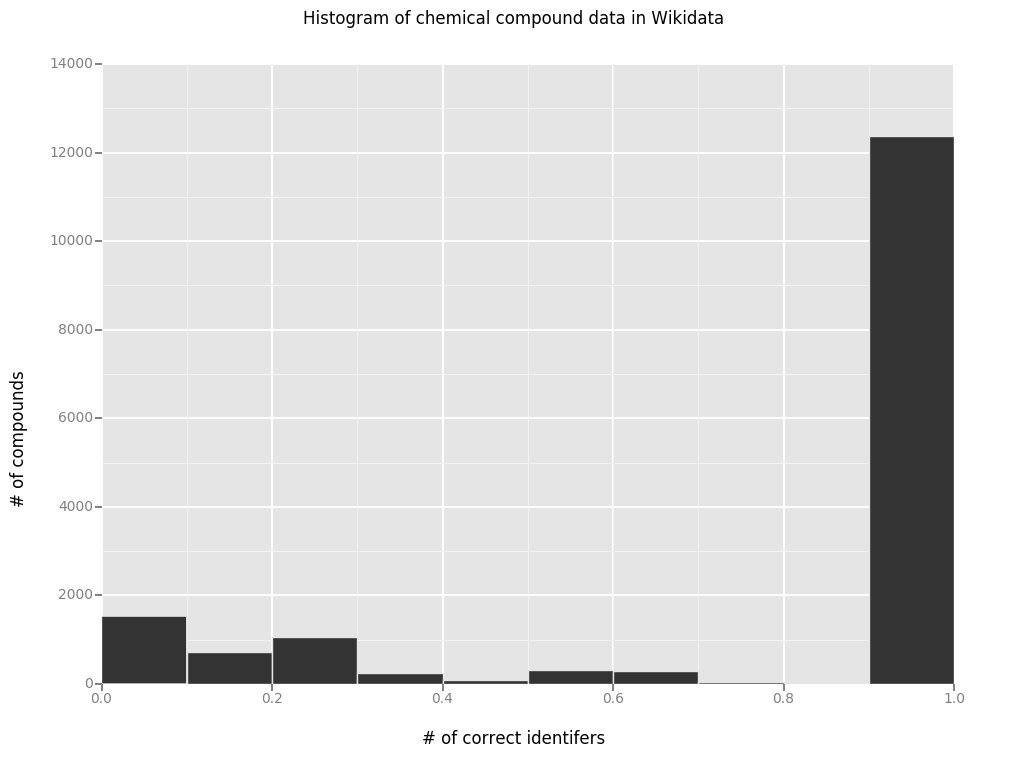

<ggplot: (8749679507534)>

In [124]:
p = ggplot(aes(x='percentage'), data=bool_df)
p + geom_histogram(bin=0.01) + ggtitle('Histogram of chemical compound data in Wikidata') + xlab('# of correct identifers') + ylab('# of compounds')
# import matplotlib.pyplot as plt

# import matplotlib
# matplotlib.style.use('ggplot')

# plt.figure();
# bool_df['percentage'].plot.hist(alpha=0.1)

In [82]:
bool_df.to_csv('bool_df_w_counts_01-2017.csv')

# How do FDA approved drugs in Wikidata perform?

In [15]:
import requests
import sys
import pandas as pd

sys.path.append('/home/sebastian/PycharmProjects/restructure/ProteinBoxBot_Core/')
import PBB_Core
import PBB_login


query = '''
SELECT * WHERE {
    ?compound wdt:P31 wd:Q12140 .
}
'''

results = PBB_Core.WDItemEngine.execute_sparql_query(query)
pharm_compounds = pd.DataFrame(columns=bool_df.columns)

for count, cmpnd in enumerate(results['results']['bindings']):
    entity = cmpnd['compound']['value']
    
    if entity in bool_df['cmpnd'].values:
        pharm_compounds = pharm_compounds.append(bool_df.loc[bool_df['cmpnd'].values == entity, :])

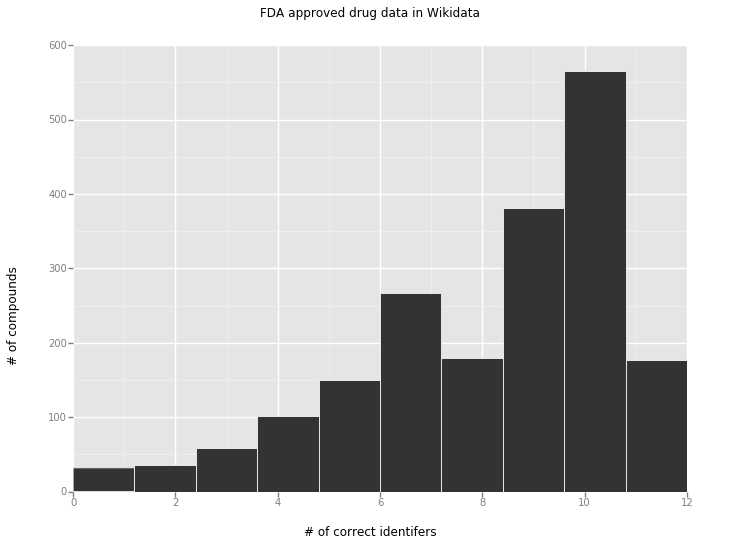

<ggplot: (8744367988151)>

In [42]:
p = ggplot(aes(x='t_count'), data=pharm_compounds)
p + geom_histogram(binwidth=1) + ggtitle('FDA approved drug data in Wikidata') + xlab('# of correct identifers') + ylab('# of compounds')

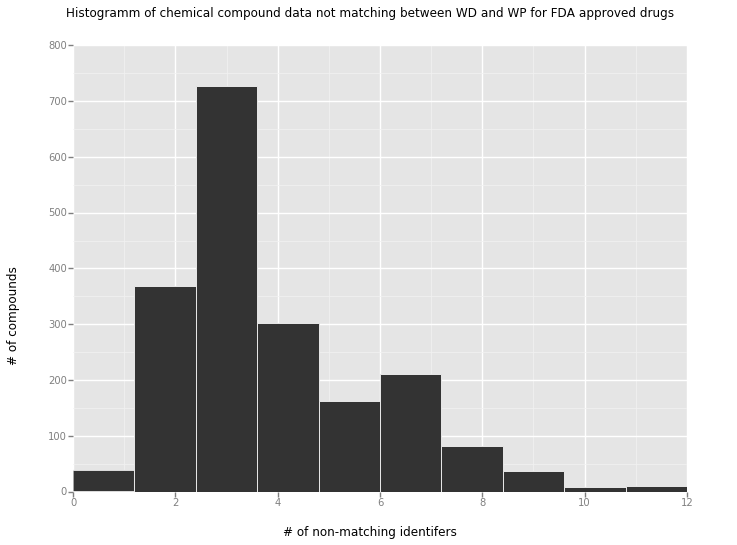

<ggplot: (8744368478833)>

In [24]:
p2 = ggplot(aes(x='f_count'), data=pharm_compounds)
p2 + geom_histogram(binwidth=1) + ggtitle('Histogramm of chemical compound data not matching between WD and WP for FDA approved drugs') + xlab('# of non-matching identifers') + ylab('# of compounds')

In [66]:
ccc = 0
for x in wp_chem_data['page_title']:
    link = 'https://en.wikipedia.org/wiki/' + x
    
    all_stuff.add(x)
    
    if link not in wd_chem_data['article'].values:
        print('| ' + link.replace(' ', '_') + ' || ' + '\n' + '|-')
        ccc += 1
print(ccc)

| https://en.wikipedia.org/wiki/BCG_vaccine||
|-
| https://en.wikipedia.org/wiki/Botulinum_toxin||
|-
| https://en.wikipedia.org/wiki/Laudanum||
|-
| https://en.wikipedia.org/wiki/MMR_vaccine||
|-
| https://en.wikipedia.org/wiki/Polio_vaccine||
|-
| https://en.wikipedia.org/wiki/Whole_blood||
|-
| https://en.wikipedia.org/wiki/Dexbrompheniramine/pseudoephedrine||
|-
| https://en.wikipedia.org/wiki/Antivenom||
|-
| https://en.wikipedia.org/wiki/Microbicides_for_sexually_transmitted_diseases||
|-
| https://en.wikipedia.org/wiki/Alpha-1_antitrypsin||
|-
| https://en.wikipedia.org/wiki/Oxygen_therapy||
|-
| https://en.wikipedia.org/wiki/Hydrocortisone||
|-
| https://en.wikipedia.org/wiki/Anti-thymocyte_globulin||
|-
| https://en.wikipedia.org/wiki/Fenfluramine/phentermine||
|-
| https://en.wikipedia.org/wiki/Oxycodone/aspirin||
|-
| https://en.wikipedia.org/wiki/Adderall||
|-
| https://en.wikipedia.org/wiki/DPT_vaccine||
|-
| https://en.wikipedia.org/wiki/Nitrous_oxide_(medication)||
|-
| 

In [12]:
cid_df = pd.read_csv('bool_df_cids.csv')
print(cid_df.dtypes)
cid_df.head()


cmpnd                object
article              object
pubchem_cid_match    object
dtype: object


,cmpnd,article,pubchem_cid_match
0,http://www.wikidata.org/entity/Q161267,"https://en.wikipedia.org/wiki/1,1,1-Trifluoroe...",True
1,http://www.wikidata.org/entity/Q161264,"https://en.wikipedia.org/wiki/1,1,1,2-Tetrachl...",True
2,http://www.wikidata.org/entity/Q161275,"https://en.wikipedia.org/wiki/1,1,2,2-Tetrachl...",True
3,http://www.wikidata.org/entity/Q161276,"https://en.wikipedia.org/wiki/1,1,2-Trichloro-...",True
4,http://www.wikidata.org/entity/Q161271,https://en.wikipedia.org/wiki/Tetrabromoethane,True


In [18]:
for c, data in cid_df.iterrows():
    if data['pubchem_cid_match'] == False:
        print('| ' + data['cmpnd'] + ' || ' + data['article'].replace(' ', '_')  + '\n' + '|-') 

| http://www.wikidata.org/entity/Q68414 || https://en.wikipedia.org/wiki/Renzapride
|-
| http://www.wikidata.org/entity/Q75892 || https://en.wikipedia.org/wiki/Capeserod
|-
| http://www.wikidata.org/entity/Q127900 || https://en.wikipedia.org/wiki/Lactose
|-
| http://www.wikidata.org/entity/Q73972 || https://en.wikipedia.org/wiki/Hydroxocobalamin
|-
| http://www.wikidata.org/entity/Q165399 || https://en.wikipedia.org/wiki/Azithromycin
|-
| http://www.wikidata.org/entity/Q165660 || https://en.wikipedia.org/wiki/Atracurium_besilate
|-
| http://www.wikidata.org/entity/Q161601 || https://en.wikipedia.org/wiki/1-Chloro-1,1-difluoroethane
|-
| http://www.wikidata.org/entity/Q161475 || https://en.wikipedia.org/wiki/1,2-Dichloroethene
|-
| http://www.wikidata.org/entity/Q81890 || https://en.wikipedia.org/wiki/Bismuth_subsalicylate
|-
| http://www.wikidata.org/entity/Q82182 || https://en.wikipedia.org/wiki/Chlorophyll_d
|-
| http://www.wikidata.org/entity/Q161547 || https://en.wikipedia.org/wiki

In [69]:
# what are the WP articles not showing up in the WP set (bc they don't have chem or drugbox)?
comp = {x[30:] for x in wd_chem_data['article'].values}.difference(set(wp_chem_data['page_title'].values))

with_cid_count = 0
with_cid_store = []
for index, x in wd_chem_data.iterrows():
    article = x['article'][30:]
    if article in comp:
        url_string = 'https://en.wikipedia.org/wiki/{}'.format(article).replace(' ', '_')
        print(url_string)
        
        if pd.notnull(wd_chem_data.loc[index, 'pubchem_cid']):
            with_cid_store.append((index, url_string))
            with_cid_count += 1

print(len(comp))
print(with_cid_count)

for x in with_cid_store:
    print(x[0], x[1])


http://en.wikipedia.org/wiki/Binary_compound
http://en.wikipedia.org/wiki/Cyclic_compound
http://en.wikipedia.org/wiki/Trypsin
http://en.wikipedia.org/wiki/Sapphire
http://en.wikipedia.org/wiki/Polyimide
http://en.wikipedia.org/wiki/Nonoxynols
http://en.wikipedia.org/wiki/Polyurethane
http://en.wikipedia.org/wiki/Polyphenylene_sulfide
http://en.wikipedia.org/wiki/Immunoglobulin_E
http://en.wikipedia.org/wiki/Sesquiterpene
http://en.wikipedia.org/wiki/Corundum
http://en.wikipedia.org/wiki/Kerosene
http://en.wikipedia.org/wiki/Natural_rubber
http://en.wikipedia.org/wiki/CDP323
http://en.wikipedia.org/wiki/Gypsum
http://en.wikipedia.org/wiki/Cellulose_acetate
http://en.wikipedia.org/wiki/Motilin
http://en.wikipedia.org/wiki/Azobilirubin
http://en.wikipedia.org/wiki/Benzodiazepine
http://en.wikipedia.org/wiki/Graphene
http://en.wikipedia.org/wiki/Pheromone
http://en.wikipedia.org/wiki/Dichlorobutane
http://en.wikipedia.org/wiki/Semaphorin
http://en.wikipedia.org/wiki/Nylon
http://en.wikipe

In [33]:
# which WD items,linked via interwiki links, do not have enought data in order to consider them 
# chemical compounds (e.g. only have an English label, but are empty otherwise)
comp = set(wp_chem_data['page_title'].values).difference({x[30:] for x in wd_chem_data['article'].values})
#set(wp_chem_data['page_title'].values)
print(len(comp))

1332


In [124]:
# determine which WP infoboxes lack CID although WD has one
wp_cid_missing_count = 0
print('''{| class="wikitable"
|-
! Wikidata item !! Wikipedia page
|-''')
for index, data in wd_chem_data.iterrows():
    article = data['article'][30:]
    cid = data['pubchem_cid']
    if pd.notnull(data['pubchem_cid']):
        if article in wp_chem_data['page_title'].values:
            wp_index = wp_chem_data['page_title'].values.tolist().index(article)
#             print(wp_chem_data['PubChem'].values[wp_index])
            if pd.isnull(wp_chem_data['PubChem'].values[wp_index]):
                
                print('| ' + get_qid(article) + ' || ' + data['article'].replace(' ', '_')  + '\n|-')
                wp_cid_missing_count += 1
print('|}')            
print(wp_cid_missing_count)

{| class="wikitable"
|-
! Wikipedia page
|-
| http://www.wikidata.org/entity/Q146123 || https://en.wikipedia.org/wiki/Poly(methyl_methacrylate)
|-
| http://www.wikidata.org/entity/Q161683 || https://en.wikipedia.org/wiki/1-Tetradecanol
|-
| http://www.wikidata.org/entity/Q161679 || https://en.wikipedia.org/wiki/Propanethiol
|-
| http://www.wikidata.org/entity/Q161287 || https://en.wikipedia.org/wiki/1,1-Difluoroethylene
|-
| http://www.wikidata.org/entity/Q161534 || https://en.wikipedia.org/wiki/1,4-Dioxin
|-
| http://www.wikidata.org/entity/Q161297 || https://en.wikipedia.org/wiki/1,2,3-Triazole
|-
| http://www.wikidata.org/entity/Q161457 || https://en.wikipedia.org/wiki/1,2-Butanediol
|-
| http://www.wikidata.org/entity/Q131994 || https://en.wikipedia.org/wiki/1,2-Dimethoxybenzene
|-
| http://www.wikidata.org/entity/Q161301 || https://en.wikipedia.org/wiki/1,2,3-Trichloropropane
|-
| http://www.wikidata.org/entity/Q161453 || https://en.wikipedia.org/wiki/1,2-Bis(diphenylphosphino)eth

In [123]:
# determine which WD item lack CID although WP infobox has one
wd_cid_missing_count = 0
interwikilinks = [x[30:] for x in wd_chem_data['article'].values]
#print(len(interwikilinks))
#print(len(set(interwikilinks)))
for index, data in wp_chem_data.iterrows():
    article = data['page_title']
    
    cid = data['PubChem']
    if pd.notnull(data['PubChem']):
        if article in interwikilinks:
            wd_index = interwikilinks.index(article)
            
            if pd.isnull(wd_chem_data['pubchem_cid'].values[wd_index]):
                print('| ' + get_qid(article) + ' || ' + 'https://en.wikipedia.org/wiki/{}'
                      .format(data['page_title']).replace(' ', '_')  + '\n|-')
                wd_cid_missing_count += 1
            
print(wd_cid_missing_count)

| http://www.wikidata.org/entity/Q682 || https://en.wikipedia.org/wiki/Sulfur
|-
| http://www.wikidata.org/entity/Q190016 || https://en.wikipedia.org/wiki/Heparin
|-
| http://www.wikidata.org/entity/Q423098 || https://en.wikipedia.org/wiki/Neomycin
|-
| http://www.wikidata.org/entity/Q282003 || https://en.wikipedia.org/wiki/Lindane
|-
| http://www.wikidata.org/entity/Q424294 || https://en.wikipedia.org/wiki/Ipratropium_bromide
|-
| http://www.wikidata.org/entity/Q418345 || https://en.wikipedia.org/wiki/Norbaeocystin
|-
| http://www.wikidata.org/entity/Q4636226 || https://en.wikipedia.org/wiki/3C-E
|-
| http://www.wikidata.org/entity/Q27094615 || https://en.wikipedia.org/wiki/Kanamycin_A
|-
| http://www.wikidata.org/entity/Q2240116 || https://en.wikipedia.org/wiki/Levocabastine
|-
| http://www.wikidata.org/entity/Q27252312 || https://en.wikipedia.org/wiki/Trospium_chloride
|-
| http://www.wikidata.org/entity/Q7250473 || https://en.wikipedia.org/wiki/Propylisopropyltryptamine
|-
| http:/